# Model interpretation

This page discusses ways to interpret machine learning models to understand why they make different decisions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.ensemble
import sklearn.inspection
import sklearn.linear_model

## Permutation importance

To estimate features importances of the arbitrary model you can use permutation importance algorithm. The idea is to randomly change some features of the input, and estimate a change of the model's quality measure - big change means that feature was important. For more details check ["Permutation feature importance"](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance), page on sklearn.

---

The code in the following cell creates a small $X \rightarrow y$ relationship dataset, so that each next column has a greater impact on the result than the previous one.

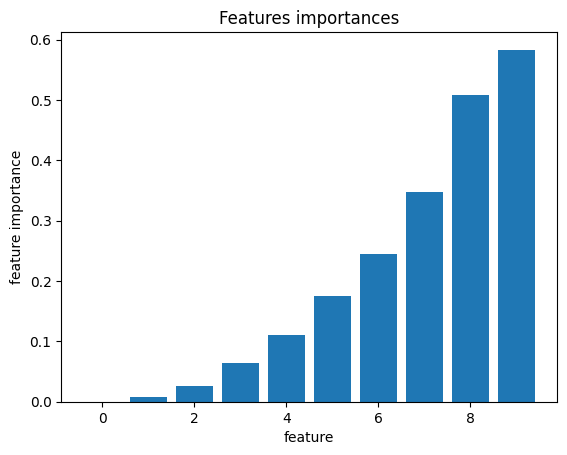

In [3]:
features_numer = 10
sample_size = 500

X = np.random.uniform(-5, 5, (sample_size, features_numer))
y = (X @ np.arange(features_numer))

model = sklearn.linear_model.LinearRegression().fit(X=X, y=y)

from sklearn.inspection import permutation_importance
importances = permutation_importance(
    estimator=model, X=X, y=y, scoring="r2"
)["importances_mean"]

plt.bar(range(importances.shape[0]), importances)
plt.xlabel("feature"), plt.ylabel("feature importance")
plt.title("Features importances")
plt.show()

As a result, other features have a greater impact on the outcome.

## Partial dependence plot

A partial dependence plot (PDP) shows how the model's output change with different values of the feature.

The purpose of the PDP is to determine the average prediction of the model with a particular feature fixed at a specific value. 

---

The following cell generates a regression task in which $y$ depends on $x_1$ and $x_2$. However, the relationship with $x_2$ is always linear. With $x_1$ it is linear until $x_1$ reaches 10, after becomes quadratic.

In [2]:
np.random.seed(2000)

sample_size = 200
X = np.stack(
    [
        np.random.normal(10, 20, sample_size),
        np.random.normal(10, 20, sample_size)
    ],
    axis=1
)

y = np.where(X[:, 0] < 10, X[:, 0] * 5, X[:, 0] ** 2) + 5 * X[:, 1]

The following cell fits the Gradient boosting regressor based on the generated task,and explains how features influence on the model using PDP.

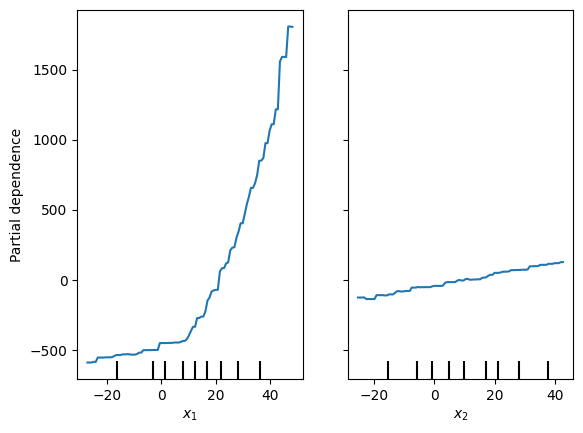

In [ ]:
model = sklearn.ensemble.GradientBoostingRegressor().fit(X, y)
sklearn.inspection.PartialDependenceDisplay.from_estimator(
    model, X,
    features=[0, 1],
    feature_names=["$x_1$", "$x_2$"]
)

After the $x_1 = 10$ threshold, the result on the PDP($x_1$) starts to grow extremely quickly, while the PDP($x_2$) maintains the same slope over the entire range of values considered.

## SHAP

SHapley Additive exPlanations is an approach for understanding the influence of particular features on model output. It is implemented in the corresponding [Python package](https://shap.readthedocs.io/en/latest/index.html).

---

Consider the practical application of SHAP using the following example. The cell below generates a regression task in which $y$ is linearly related to $x_1$, while $x_2$ has no influence on $y$ until $x_1$ reaches the threshold of 0. Once this threshold is crossed, $x_2$ starts to increase $y$ linearly. A gradient boosting model is then fitted to the generated data.

In [53]:
sample_size = 200
X = np.stack(
    [
        np.random.normal(0, 5, sample_size),
        np.random.normal(0, 5, sample_size)
    ],
    axis=1
)
y = X[:, 0] + np.where(X[:, 1] < 0, 0, X[:, 1])
model = sklearn.ensemble.GradientBoostingRegressor().fit(X, y)

SHAP must see the samples that describe the process and predictions of the model under consideration.

In [54]:
import shap
explainer = shap.Explainer(model.predict, X)

SHAP returns the influence of the features on a specific model outcome. Consider a few valuable examples.

Here is the model's output when $x_2$ is smaller than the threshold. In this case, $x_2$ has almost no influence on the solutions taken by the model.

In [55]:
explainer(np.array([[5, 2]]))

.values =
array([[4.41641631, 0.09548967]])

.base_values =
array([2.32590284])

.data =
array([[5, 2]])

And the SHAP output for case where $x_2$ influences the $y$.

In [56]:
explainer(np.array([[5, 18]]))

.values =
array([[3.76072325, 7.5146348 ]])

.base_values =
array([2.32590284])

.data =
array([[ 5, 18]])

As expected, the contribution of $x_2$ is more significant here.

Consider how the SHAP value for $x_2$ ($SHAP(x_2)$) depends on $x_2$ in the context of the given example.

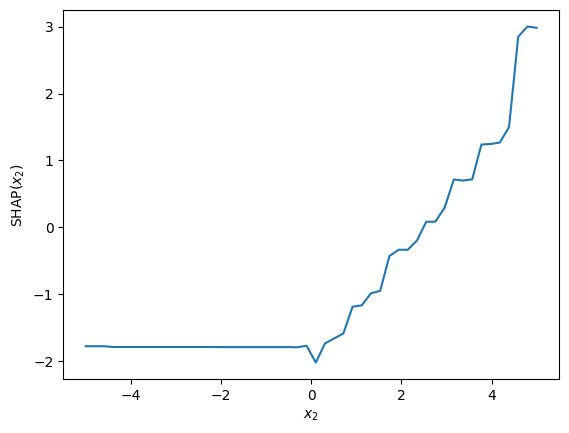

In [76]:
points = np.stack([
    np.zeros(50),
    np.linspace(-5, 5, 50)
], axis=1)

shap_values = explainer(points).values[:, 1]
plt.plot(points[:, 1], shap_values)
plt.xlabel("$x_2$")
plt.ylabel("SHAP($x_2$)")
plt.show()

It doesn't influence the model until the threshold is reached; however, at higher values of $x_2$, it begins to play a crusial role in making predictions.